# Partition Script by Year and Map Lines

## Repeat data cleaning to keep ID

In [1]:
# Import pandas for data frame
import pandas as pd

In [2]:
# Read in cleaned .csv file and convert to data frame
simpsons_script = pd.read_csv("simpsons_df_fixed.csv")['raw_text']
simpsons_script = simpsons_script.to_frame()
simpsons_script.head()

,raw_text
0,ooo careful homer
1,theres no time to be careful
2,were late
3,hushed voice sorry excuse us pardon me
4,simultaneously hey norman hows it going so yo...


In [3]:
# Import raw .csv file, sort by ID and resetting index
ss_raw = pd.read_csv("The Simpsons Data/simpsons_script_lines.csv")
ss_raw = ss_raw.sort_values(by = ['id'])
ss_raw = ss_raw.reset_index()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Remove non-spoken lines
ss_raw = ss_raw[ss_raw.speaking_line.isin(["true", True])]

In [5]:
# Extract episode ID
ss_raw = ss_raw.reset_index()
ss_raw = ss_raw['episode_id']

In [6]:
# Append to main data frame of cleaned text
simpsons_script['Episode_ID'] = ss_raw

In [7]:
# Read in episode data
episodes = pd.read_csv("The Simpsons Data/simpsons_episodes.csv")

In [8]:
# Filter out years
episodes = episodes[['id','original_air_date','original_air_year']]

In [9]:
# Sort by ID
episodes = episodes.sort_values(by = ['id'])
episodes.head()

,id,original_air_date,original_air_year
241,1,1989-12-17,1989
242,2,1990-01-14,1990
550,3,1990-01-21,1990
243,4,1990-01-28,1990
525,5,1990-02-04,1990


In [10]:
# Create dictionary of episode ID to year
id_year = pd.Series(episodes.original_air_year.values, index = episodes.id).to_dict()

In [11]:
# Append to data frame
simpsons_script['Year'] = simpsons_script['Episode_ID'].map(id_year)
simpsons_script.head()

,raw_text,Episode_ID,Year
0,ooo careful homer,1,1989
1,theres no time to be careful,1,1989
2,were late,1,1989
3,hushed voice sorry excuse us pardon me,1,1989
4,simultaneously hey norman hows it going so yo...,1,1989


In [12]:
# Import library for VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/AthenaXiourouppa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
# Assign sentiment analyser as VADER
vader = SentimentIntensityAnalyzer()

In [14]:
# Calculate sentiment for each line and append to data frame
simpsons_script['VADER_Sentiment'] = [vader.polarity_scores(word) for word in simpsons_script.raw_text]

In [15]:
# Isolate compound value
simpsons_script['VADER_Compound_Score'] = [simpsons_script.iloc[i].VADER_Sentiment['compound'] for i in range(len(simpsons_script))]

In [16]:
# Create empty dictionary
simpsons_byyear = {elem: pd.DataFrame for elem in episodes.original_air_year.unique()}

In [17]:
# Create separate dataframes for each year
for key in simpsons_byyear.keys():
    simpsons_byyear[key] = simpsons_script[:][simpsons_script.Year == key]

## Analyse Each Year

In [19]:
# Import relevant gensim and NLTK packages
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/AthenaXiourouppa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Preprocessing function
def preprocess_nostem(text):
    # Initialise array
    result = []
    # Remove stopwords
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [21]:
# Create empty dictionary
simpsons_byyear_tokenized = {elem: pd.DataFrame for elem in episodes.original_air_year.unique()}

In [22]:
# Iterate through data frames, remove stopwords, grammar
for key in simpsons_byyear_tokenized.keys():
    ss_year = simpsons_byyear[key]['raw_text']
    ss_year = str(ss_year)
    ss_year = re.sub(r'[^\w\s]','',ss_year)
    ss_year = preprocess_nostem(ss_year)
    simpsons_byyear_tokenized[key] = ss_year

In [23]:
# Import frequency distribution
from nltk.probability import FreqDist

In [24]:
# Create empty dictionary for top words
simpsons_byyear_fdist = {elem: pd.DataFrame for elem in episodes.original_air_year.unique()}

In [25]:
# Append most common word per year into dictionary and view
common_byyear = []

for key in simpsons_byyear_fdist.keys():
    simpsons_byyear_fdist[key] = FreqDist(simpsons_byyear_tokenized[key])
    common_byyear.append(simpsons_byyear_fdist[key].most_common(1))

common_byyear

[[('homer', 3)],
 [('come', 1)],
 [('calling', 1)],
 [('money', 2)],
 [('homer', 3)],
 [('thats', 3)],
 [('like', 2)],
 [('thats', 2)],
 [('laughs', 2)],
 [('waiting', 2)],
 [('whatchu', 2)],
 [('camel', 2)],
 [('pony', 3)],
 [('accustomed', 3)],
 [('sing', 3)],
 [('thats', 1)],
 [('party', 3)],
 [('grumply', 6)],
 [('arent', 2)],
 [('urgent', 2)],
 [('youre', 2)],
 [('love', 1)],
 [('dodgeball', 1)],
 [('grumpy', 1)],
 [('learn', 2)],
 [('birth', 3)],
 [('monotone', 2)],
 [('series', 1)]]

In [26]:
# Create dictionary of Line ID to year
line_year = pd.Series(simpsons_script.Year, index = simpsons_script.index).to_dict()

In [26]:
# Store dictionary for lines in other notebooks
%store line_year

Stored 'line_year' (dict)


In [27]:
# Import statistics package for year
import statistics

In [28]:
# Create vector of average yearly sentiment and view
sentiment_avg_byyear = []

for key in simpsons_byyear.keys():
    yearly_sentiment_column = simpsons_byyear[key]['VADER_Compound_Score']
    if len(yearly_sentiment_column) > 0:
        sentiment_avg_byyear.append(statistics.mean(yearly_sentiment_column))
        
sentiment_avg_byyear

[0.10565195195195196,
 0.07282366270430907,
 0.08201716089254257,
 0.0660776514478593,
 0.05251227895887145,
 0.060003253796095446,
 0.05079534069013838,
 0.07763019943019943,
 0.061417038571883964,
 0.05463854833277198,
 0.0662208947885939,
 0.06473461397058823,
 0.061074614305750355,
 0.04984109775019395,
 0.07370469597754911,
 0.05987945324365372,
 0.05552559502664298,
 0.05295683117983478,
 0.039897443000213084,
 0.06966641585151744,
 0.062003139980824545,
 0.06036471694564604,
 0.06588222314737718,
 0.04866196162046908,
 0.06368547652070537,
 0.05539960267670431,
 0.08780974493132766]

In [30]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

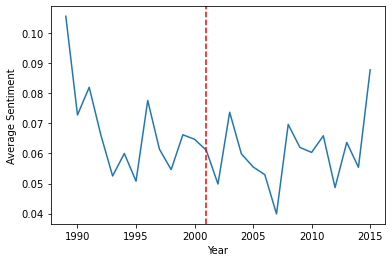

In [31]:
plt.plot(range(1989,2016), sentiment_avg_byyear)

# Axis labels and legend
plt.xlabel("Year")
plt.ylabel("Average Sentiment")

# Vertical line indicating 9/11
plt.axvline(x = 2001, color = 'r', linestyle = '--')

# Save figure
plt.savefig('sentiment_year_avg.eps')
plt.show()